<h1 align=center> TNEB - Load Forecasting </h1>

<h2 align=center> Short-term forecasting with lockdown and weather information </h2>



<h4 align=left> This notebook contains the following </h4>

* Hourly D-7 forecasting

* Hourly D-1 forecasting

* Hourly H-4 intraday forecasting

* 5% error maximum

---
Dr Yuchang Wang

February, 2021

---

# 1. Import prerequisites

In [1]:
!date

Wed 10 Feb 15:07:53 GMT 2021


In [2]:
import numpy as np
import pandas as pd 
from math import radians, cos, sin, asin, sqrt
import math

# plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# time
import time
from datetime import datetime as dt
from datetime import timedelta

# prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.make_holidays import make_holidays_df
import holidays

import utils
import models

In [3]:
# disable the sdout logging of fbprophet

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

In [4]:
# ignore the pystan DeprecationWarning

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

In [5]:
# GLOBAL VARIABLE

divider = '2020-09-01'

# 2. Import data

,ds,y
101949,2020-11-30 11:30:00,11656.7
101950,2020-11-30 11:45:00,11797.5
101951,2020-11-30 12:00:00,11980.3
101952,2020-11-30 12:15:00,11812.6
101953,2020-11-30 12:30:00,11789.9


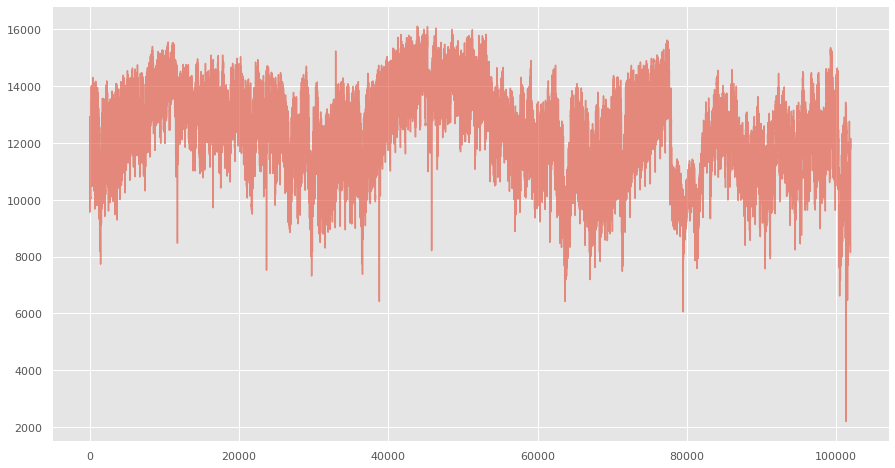

In [6]:
# read 'prophet_raw.csv' which is cleaned [15 mins interval] to df 

df_pp = pd.read_csv('prophet_raw.csv', low_memory=False)

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = df_pp.y.plot(alpha=0.6)

df_pp.tail()

# 3. Prophet

## 3.1 Prepare data for fbprophet

In [7]:
# Resampling 

df_hh, df_h, df_d = utils.df_resampling(df_pp)

# Train and test sets split

# split dataset into train (2018-2020-08-31) and test (2020-09-01)

# df_pp 15 mins interval
df_train_quar, df_test_quar = utils.df_train_test_split(df_pp, divider)

# df_hh 30 mins interval
df_train_hh, df_test_hh = utils.df_train_test_split(df_hh, divider)

# df_h 60 mins interval
df_train_h, df_test_h = utils.df_train_test_split(df_h, divider)

# df_d  24 hrs interval
df_train_d, df_test_d = utils.df_train_test_split(df_d, divider)

In [8]:
df_train_h.tail()

,ds,y
23371,2020-08-31 19:00:00,12844.650
23372,2020-08-31 20:00:00,12706.875
23373,2020-08-31 21:00:00,12619.125
23374,2020-08-31 22:00:00,12679.050
23375,2020-08-31 23:00:00,12226.100


## 3.2 Models

### 3.2.1 Model 1: fbprophet baseline model

In [9]:
# m1, forecast1, cv_results1 = models.baseline(df_train_60, freq='H', periods=24*7, cv_flag=0)

m1 = Prophet()
m1.fit(df_train_h)


In [ ]:
# validation for the model 

# cv_results1 = utils.cv_results(m1, cv_flag=1)
cv_results1 = cross_validation(m1, initial='365 days', period='90 days', horizon='7 days')
cv_results1 = cv_results1[cv_results1.y != 0]

mape1 = utils.cv_mape(cv_results1.y, cv_results1.yhat)
print('Model1 - fbprophet cross validation mean absolute percentage error (MAPE): {}'.format(mape1))

#### D-7 forecasting

In [ ]:
future1_D7 = m1.make_future_dataframe(freq='H', periods=24*7)
forecast1_D7 = m1.predict(future1_D7)

In [ ]:
fig_changepoints1_D7 = utils.plot_changepoints(m1, forecast1_D7)
fig_components1_D7 = utils.plot_components(m1, forecast1_D7)

In [ ]:
# validation

verification1_D7 = utils.df_verification(forecast1_D7, df_train_h, df_test_h)
verif_fig1_D7 = utils.plot_verification(verification1_D7, divider)
verif_fig1_D7_zoom = utils.plot_verification(verification1_D7[verification1_D7.index >= '2020-08-01'], divider)

mape1_D7 = utils.cv_mape(verification1_D7.y, verification1_D7.yhat)
print('Model 1 MAPE for D-7 forecasting: {}'.format(mape1_D7))

# plot joint plot for train set
verif_train1_D7 = verification1_D7[verification1_D7.index < divider]
mape1_train_D7 = utils.cv_mape(verif_train1_D7.y, verif_train1_D7.yhat)
print('Model 1 (Train Set) MAPE for D-7 forecasting: {}'.format(mape1_train_D7))
joint_train_plot1_D7 = utils.plot_joint_plot(verif_train1_D7, title='Train Set')


# plot joint plot for test set
verif_test1_D7 = verification1_D7[verification1_D7.index >= divider]
mape1_test_D7 = utils.cv_mape(verif_test1_D7.y, verif_test1_D7.yhat)
print('Model 1 (Test Set) MAPE for D-7 forecasting: {}'.format(mape1_test_D7))
joint_test_plot1_D7 = utils.plot_joint_plot(verif_test1_D7, title='Test Set')

# plot residual distribution plot for train set
residual_train_plot1_D7 = utils.plot_residuals_dist(verif_train1_D7, title='Train Set')

# plot residual distribution plot for test set
residual_test_plot1_D7 = utils.plot_residuals_dist(verif_test1_D7, title='Test Set')

#### D-1 forecasting

In [ ]:
future1_D1 = m1.make_future_dataframe(freq='H', periods=24)
forecast1_D1 = m1.predict(future1_D1)

In [ ]:
fig_changepoints1_D1 = utils.plot_changepoints(m1, forecast1_D1)
fig_components1_D1 = utils.plot_components(m1, forecast1_D1)

In [ ]:
# validation

verification1_D1 = utils.df_verification(forecast1_D1, df_train_h, df_test_h)
verif_fig1_D1 = utils.plot_verification(verification1_D1, divider)
verif_fig1_D1_zoom = utils.plot_verification(verification1_D1[verification1_D1.index >= '2020-08-01'], divider)

mape1_D1 = utils.cv_mape(verification1_D1.y, verification1_D1.yhat)
print('Model 1 MAPE for D-1 forecasting: {}'.format(mape1_D1))

# plot joint plot for train set
verif_train1_D1 = verification1_D1[verification1_D1.index < divider]
mape1_train_D1 = utils.cv_mape(verif_train1_D1.y, verif_train1_D1.yhat)
print('Model 1 (Train Set) MAPE for D-1 forecasting: {}'.format(mape1_train_D1))
joint_train_plot1_D1 = utils.plot_joint_plot(verif_train1_D1, title='Train Set')

# plot joint plot for test set
verif_test1_D1 = verification1_D1[verification1_D1.index >= divider]
mape1_test_D1 = utils.cv_mape(verif_test1_D1.y, verif_test1_D1.yhat)
print('Model 1 (Test Set) MAPE for D-1 forecasting: {}'.format(mape1_test_D1))
joint_test_plot1_D1 = utils.plot_joint_plot(verif_test1_D1, title='Test Set')

# plot residual distribution plot for train set
residual_train_plot1_D1 = utils.plot_residuals_dist(verif_train1_D1, title='Train Set')

# plot residual distribution plot for test set
residual_test_plot1_D1 = utils.plot_residuals_dist(verif_test1_D1, title='Test Set')

#### H-4 forecasting

In [ ]:
future1_H4 = m1.make_future_dataframe(freq='H', periods=4)
forecast1_H4 = m1.predict(future1_H4)

In [ ]:
fig_changepoints1_H4 = utils.plot_changepoints(m1, forecast1_H4)
fig_components1_H4 = utils.plot_components(m1, forecast1_H4)

In [ ]:
# validation

verification1_H4 = utils.df_verification(forecast1_H4, df_train_h, df_test_h)
verif_fig1_H4 = utils.plot_verification(verification1_H4, divider)
verif_fig1_H4_zoom = utils.plot_verification(verification1_H4[verification1_H4.index >= '2020-08-01'], divider)

mape1_H4 = utils.cv_mape(verification1_H4.y, verification1_H4.yhat)
print('Model 1 MAPE for H-4 forecasting: {}'.format(mape1_H4))

# plot joint plot for train set
verif_train1_H4 = verification1_H4[verification1_H4.index < divider]
mape1_train_H4 = utils.cv_mape(verif_train1_H4.y, verif_train1_H4.yhat)
print('Model 1 (Train Set) MAPE for H-4 forecasting: {}'.format(mape1_train_H4))
joint_train_plot1_H4 = utils.plot_joint_plot(verif_train1_H4, title='Train Set')

# plot joint plot for test set
verif_test1_H4 = verification1_H4[verification1_H4.index >= divider]
mape1_test_H4 = utils.cv_mape(verif_test1_H4.y, verif_test1_H4.yhat)
print('Model 1 (Test Set) MAPE for H-4 forecasting: {}'.format(mape1_test_H4))
joint_test_plot1_H4 = utils.plot_joint_plot(verif_test1_H4, title='Test Set')

# plot residual distribution plot for train set
residual_train_plot1_H4 = utils.plot_residuals_dist(verif_train1_H4, title='Train Set')

# plot residual distribution plot for test set
residual_test_plot1_H4 = utils.plot_residuals_dist(verif_test1_H4, title='Test Set')

### 3.2.2 Model 2: fbprophet lockdown and custom holiday model

* add custom holiday as holiday `df`

* add lockdown periods as regressors

In [ ]:
%%time
# add lockdown and custom holiday in India, Tamil Nadu

lockdown_holiday_df = utils.add_lockdown_as_holidays_df()
custom_holiday_df = utils.add_custom_holidays()
holiday_df = pd.concat([custom_holiday_df, lockdown_holiday_df])

# add holiday
m2 = Prophet(holidays=custom_holiday_df)

# m2.add_seasonality(name='yearly', period=365.25, fourier_order=10, 
#                   prior_scale=10, 
#                   mode='multiplicative')

# add lockdown regressor
df_with_lockdown_regressors = utils.add_lockdown_as_regressors(df_train_h)

m2.add_regressor('during_lockdown', mode='additive')
m2.add_regressor('during_regional_lockdown', mode='additive')
m2.add_regressor('during_lockdown_with_relaxation', mode='additive')
m2.add_regressor('after_lockdown', mode='additive')

m2.fit(df_with_lockdown_regressors)

# m2.fit(df_train_h)

In [ ]:
%%time
# validation for the model 
# cv_results2 = utils.cv_results(m2, cv_flag=1)
cv_results2 = cross_validation(m2, initial='365 days', period='90 days', horizon='7 days')
cv_results2 = cv_results2[cv_results2.y != 0]

mape2 = utils.cv_mape(cv_results2.y, cv_results2.yhat)
print('Model2 - fbprophet cross validation mean absolute percentage error (MAPE): {}'.format(mape2))

#### D-7 forecasting

In [ ]:
future2_D7 = m2.make_future_dataframe(freq='H', periods=24*7)
    
future_with_lockdown_regressors2_D7 = utils.add_lockdown_as_regressors(future2_D7)

forecast2_D7 = m2.predict(future_with_lockdown_regressors2_D7)

# forecast2_D7 = m2.predict(future2_D7)

In [ ]:
fig_changepoints2_D7 = utils.plot_changepoints(m2, forecast2_D7)
fig_components2_D7 = utils.plot_components(m2, forecast2_D7)

In [ ]:
# validation

verification2_D7 = utils.df_verification(forecast2_D7, df_train_h, df_test_h)
verif_fig2_D7 = utils.plot_verification(verification2_D7, divider)
verif_fig2_D7_zoom = utils.plot_verification(verification2_D7[verification2_D7.index >= '2020-08-01'], divider)

mape2_D7 = utils.cv_mape(verification2_D7.y, verification2_D7.yhat)
print('Model 2 MAPE for D-7 forecasting: {}'.format(mape2_D7))

# plot joint plot for train set
verif_train2_D7 = verification2_D7[verification2_D7.index < divider]
mape2_train_D7 = utils.cv_mape(verif_train2_D7.y, verif_train2_D7.yhat)
print('Model 2 (Train Set) MAPE for D-7 forecasting: {}'.format(mape2_train_D7))
joint_train_plot2_D7 = utils.plot_joint_plot(verif_train2_D7, title='Train Set')

# plot joint plot for test set
verif_test2_D7 = verification2_D7[verification2_D7.index >= divider]
mape2_test_D7 = utils.cv_mape(verif_test2_D7.y, verif_test2_D7.yhat)
print('Model 2 (Test Set) MAPE for D-7 forecasting: {}'.format(mape2_test_D7))
joint_test_plot2_D7 = utils.plot_joint_plot(verif_test2_D7, title='Test Set')

# plot residual distribution plot for train set
residual_train_plot2_D7 = utils.plot_residuals_dist(verif_train2_D7, title='Train Set')

# plot residual distribution plot for test set
residual_test_plot2_D7 = utils.plot_residuals_dist(verif_test2_D7, title='Test Set')

#### D-1 forecasting

In [ ]:
future2_D1 = m2.make_future_dataframe(freq='H', periods=24)

future_with_lockdown_regressors2_D1 = utils.add_lockdown_as_regressors(future2_D1)

forecast2_D1 = m2.predict(future_with_lockdown_regressors2_D1)

In [ ]:
fig_changepoints2_D1 = utils.plot_changepoints(m2, forecast2_D1)
fig_components2_D1 = utils.plot_components(m2, forecast2_D1)

In [ ]:
# validation

verification2_D1 = utils.df_verification(forecast2_D1, df_train_h, df_test_h)
verif_fig2_D1 = utils.plot_verification(verification2_D1, divider)
verif_fig2_D1_zoom = utils.plot_verification(verification2_D1[verification2_D1.index >= '2020-08-01'], divider)

mape2_D1 = utils.cv_mape(verification2_D1.y, verification2_D1.yhat)
print('Model 2 MAPE for D-1 forecasting: {}'.format(mape2_D1))

# plot joint plot for train set
verif_train2_D1 = verification2_D1[verification2_D1.index < divider]
mape2_train_D1 = utils.cv_mape(verif_train2_D1.y, verif_train2_D1.yhat)
print('Model 2 (Train Set) MAPE for D-1 forecasting: {}'.format(mape2_train_D1))
joint_train_plot2_D1 = utils.plot_joint_plot(verif_train2_D1, title='Train Set')

# plot joint plot for test set
verif_test2_D1 = verification2_D1[verification2_D1.index >= divider]
mape2_test_D1 = utils.cv_mape(verif_test2_D1.y, verif_test2_D1.yhat)
print('Model 2 (Test Set) MAPE for D-1 forecasting: {}'.format(mape2_test_D1))
joint_test_plot2_D1 = utils.plot_joint_plot(verif_test2_D1, title='Test Set')

# plot residual distribution plot for train set
residual_train_plot2_D1 = utils.plot_residuals_dist(verif_train2_D1, title='Train Set')

# plot residual distribution plot for test set
residual_test_plot2_D1 = utils.plot_residuals_dist(verif_test2_D1, title='Test Set')

#### H-4 forecasting

In [ ]:
future2_H4 = m2.make_future_dataframe(freq='H', periods=4)

future_with_lockdown_regressors2_H4 = utils.add_lockdown_as_regressors(future2_H4)

forecast2_H4 = m2.predict(future_with_lockdown_regressors2_H4)

In [ ]:
fig_changepoints2_H4 = utils.plot_changepoints(m2, forecast2_H4)
fig_components2_H4 = utils.plot_components(m2, forecast2_H4)

In [ ]:
# validation

verification2_H4 = utils.df_verification(forecast2_H4, df_train_h, df_test_h)
verif_fig2_H4 = utils.plot_verification(verification2_H4, divider)
verif_fig2_H4_zoom = utils.plot_verification(verification2_H4[verification2_H4.index >= '2020-08-01'], divider)

mape2_H4 = utils.cv_mape(verification2_H4.y, verification2_H4.yhat)
print('Model 2 MAPE for H-4 forecasting: {}'.format(mape2_H4))

# plot joint plot for train set
verif_train2_H4 = verification2_H4[verification2_H4.index < divider]
mape2_train_H4 = utils.cv_mape(verif_train2_H4.y, verif_train2_H4.yhat)
print('Model 2 (Train Set) MAPE for H-4 forecasting: {}'.format(mape2_train_H4))
joint_train_plot2_H4 = utils.plot_joint_plot(verif_train2_H4, title='Train Set')

# plot joint plot for test set
verif_test2_H4 = verification2_H4[verification2_H4.index >= divider]
mape2_test_H4 = utils.cv_mape(verif_test2_H4.y, verif_test2_H4.yhat)
print('Model 2 (Test Set) MAPE for H-4 forecasting: {}'.format(mape2_test_H4))
joint_test_plot2_H4 = utils.plot_joint_plot(verif_test2_H4, title='Test Set')

# plot residual distribution plot for train set
residual_train_plot2_H4 = utils.plot_residuals_dist(verif_train2_H4, title='Train Set')

# plot residual distribution plot for test set
residual_test_plot2_H4 = utils.plot_residuals_dist(verif_test2_H4, title='Test Set')

### 3.2.3 Model 3: fbprophet with weather regressor

* add custom holiday as holiday `df`

* add lockdown periods as regressors

* add extra weather (daily temperature) as regressor

#### Import weather data

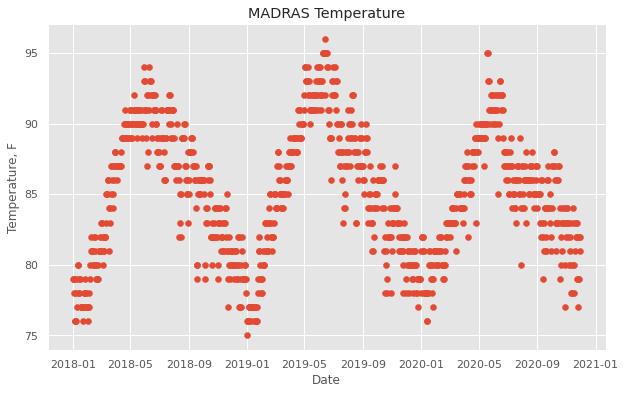

In [10]:
# read weather data

temp = pd.read_csv('data/noaa-2426560.csv')
temp['ds'] = pd.to_datetime(temp.DATE)
temp['temp'] = temp['TAVG']
# interpolate so that there are no missing values
temp = temp.interpolate(method='linear')
temp = temp.loc[:, ['ds', 'temp']]

# scatter plot of temperature

plt.figure(figsize=(10, 6))
plt.scatter(x=temp['ds'], y=temp['temp'])
plt.title('MADRAS Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature, F')
plt.show()

In [11]:
# resample `temp` first then interpolate with `spline`

if not isinstance(temp.index, pd.DatetimeIndex): # if index is not DatetimeIndex
    temp = temp.set_index('ds')

# upsample fill the `NaN` values using the `pad` method
h = temp.copy().resample('H').pad()
hh = temp.copy().resample('30T').pad()
quar = temp.copy().resample('15T').pad()

temp_h = h.reset_index()
temp_hh = hh.reset_index()
temp_quar = quar.reset_index()

# # upsample fill the `NaN` values using the `pad` method
# h_s = temp.copy().resample('H').asfreq()
# hh_s = temp.copy().resample('30T').asfreq()
# quar_s = temp.copy().resample('15T').asfreq()

# temp_h_s = h_s.reset_index()
# temp_hh_s = hh_s.reset_index()
# temp_quar_s = quar_s.reset_index()

# # interpolate with `spline` - smoothed 
# temp_h_s = temp_h_s.interpolate(method='spline', order=3)
# temp_hh_s = temp_hh_s.interpolate(method='spline', order=3)
# temp_quar_s = temp_quar_s.interpolate(method='spline', order=3)

In [12]:
%%time

# lockdown_holiday_df = utils.add_lockdown_as_holidays_df()
custom_holiday_df = utils.add_custom_holidays()
# holiday_df = pd.concat([custom_holiday_df, lockdown_holiday_df])

m3 = Prophet(holidays=custom_holiday_df)

# m3.add_seasonality(name='yearly', period=365.25, fourier_order=3, 
#                   prior_scale=10, 
#                   mode='additive')

df_with_lockdown_regressors = utils.add_lockdown_as_regressors(df_train_h)

m3.add_regressor('during_lockdown', mode='additive')
m3.add_regressor('during_regional_lockdown', mode='additive')
m3.add_regressor('during_lockdown_with_relaxation', mode='additive')
m3.add_regressor('after_lockdown', mode='additive')

# add weather regressor
df_with_weather_regressors = utils.add_regressor(df_train_h, temp_h.loc[temp_h['ds'] < divider, :], varname='temp')
m3.add_regressor('temp', prior_scale=0.5, mode='multiplicative')

# combine regressors
df_with_regressors = utils.add_regressor(df_with_lockdown_regressors, df_with_weather_regressors, varname='temp')

m3.fit(df_with_regressors)

/home/yuchang/anaconda3/envs/ts/lib/python3.8/site-packages/fbprophet/hdays.py:259: Warning: We only support Diwali and Holi holidays from 2010 to 2030
  warnings.warn(warning_msg, Warning)


CPU times: user 1min 44s, sys: 208 ms, total: 1min 44s
Wall time: 1min 44s


In [13]:
%%time
# validation for the model 
# cv_results3 = utils.cv_results(m3, cv_flag=1)
cv_results3 = cross_validation(m3, initial='365 days', period='90 days', horizon='7 days')
cv_results3 = cv_results3[cv_results3.y != 0]

mape3 = utils.cv_mape(cv_results3.y, cv_results3.yhat)
print('Model3 - fbprophet cross validation mean absolute percentage error (MAPE): {}'.format(mape3))

100%|██████████| 7/7 [06:53<00:00, 59.11s/it]

Model3 - fbprophet cross validation mean absolute percentage error (MAPE): 5.518577785508409
CPU times: user 7min 55s, sys: 1min 12s, total: 9min 8s
Wall time: 6min 54s


#### D-7 forecasting

In [15]:
future3_D7 = m3.make_future_dataframe(freq='H', periods=24*7)
    
future_with_lockdown_regressors3_D7 = utils.add_lockdown_as_regressors(future3_D7)
future_with_regressors3_D7 = utils.add_regressor(future_with_lockdown_regressors3_D7, temp_h, varname='temp')

forecast3_D7 = m3.predict(future_with_regressors3_D7)

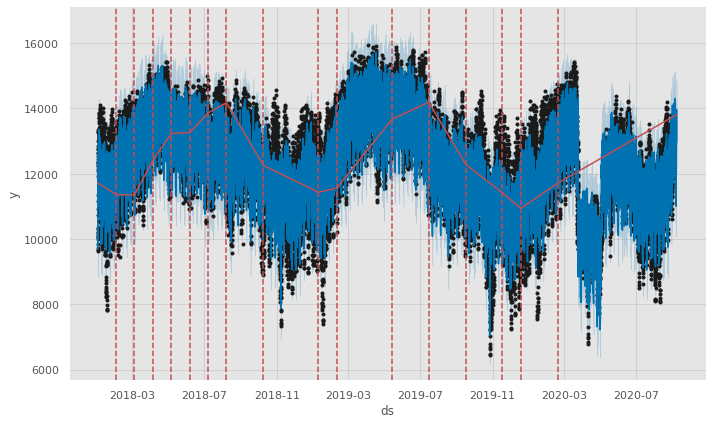

/home/yuchang/anaconda3/envs/ts/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


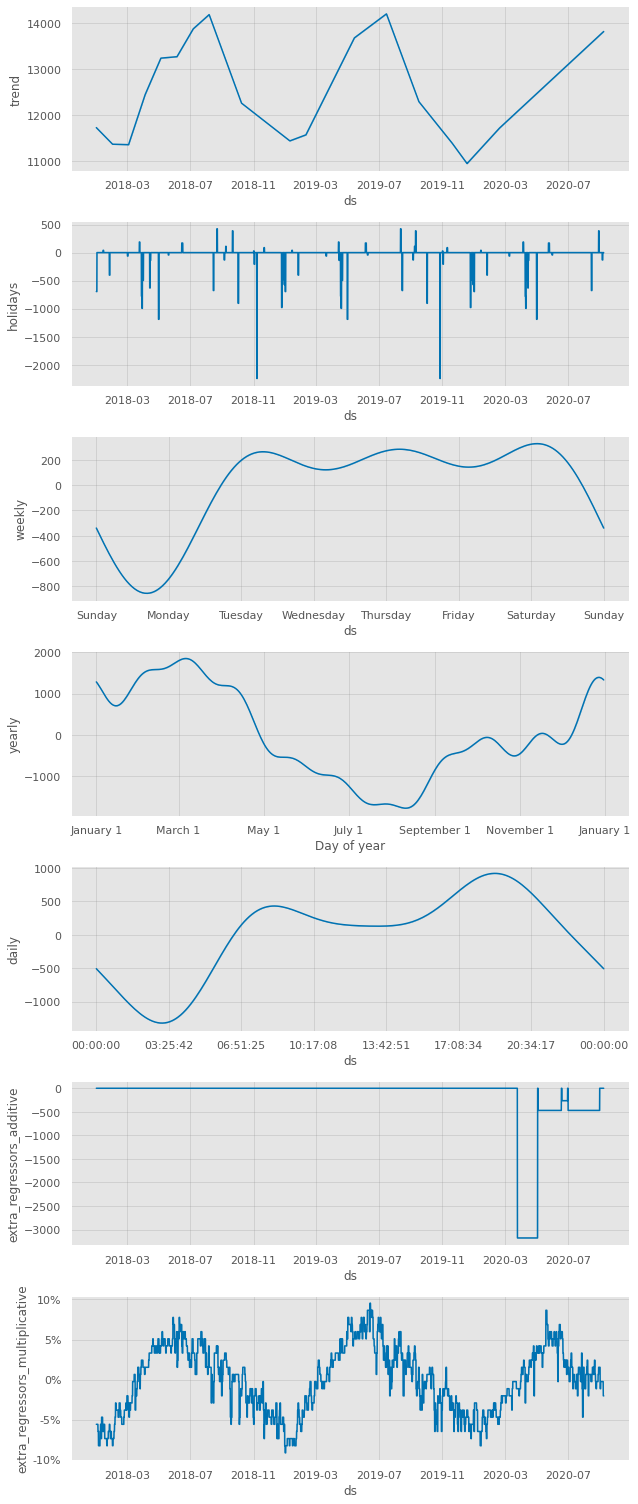

In [16]:
fig_changepoints3_D7 = utils.plot_changepoints(m3, forecast3_D7)
fig_components3_D7 = utils.plot_components(m3, forecast3_D7)

Model 3 MAPE for D-7 forecasting: 4.747406582113911
Model 3 (Train Set) MAPE for D-7 forecasting: 4.6873337918263
Model 3 (Test Set) MAPE for D-7 forecasting: 13.106106259275624


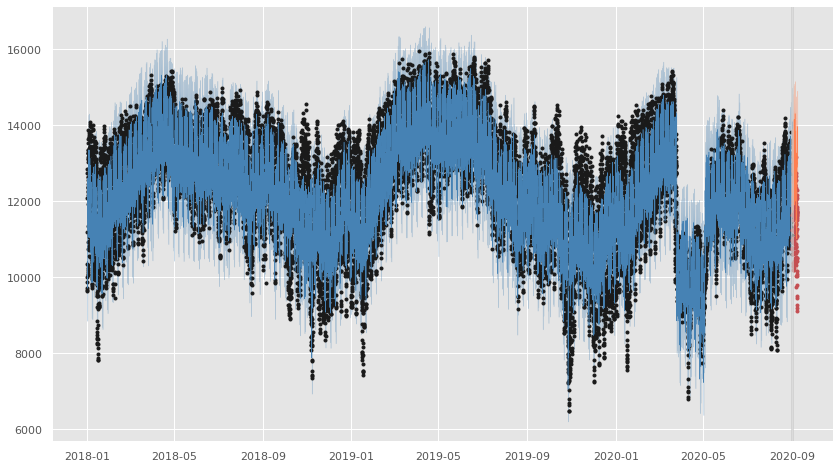

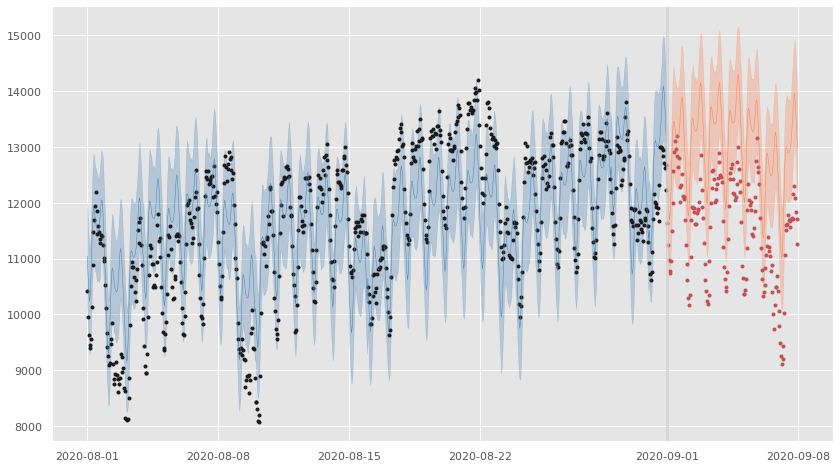

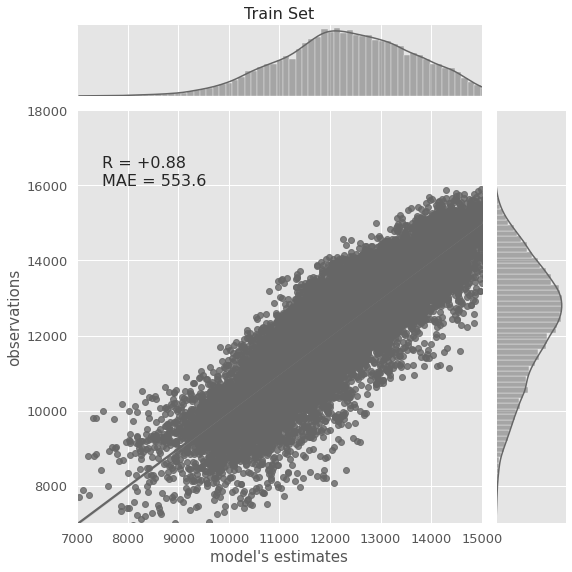

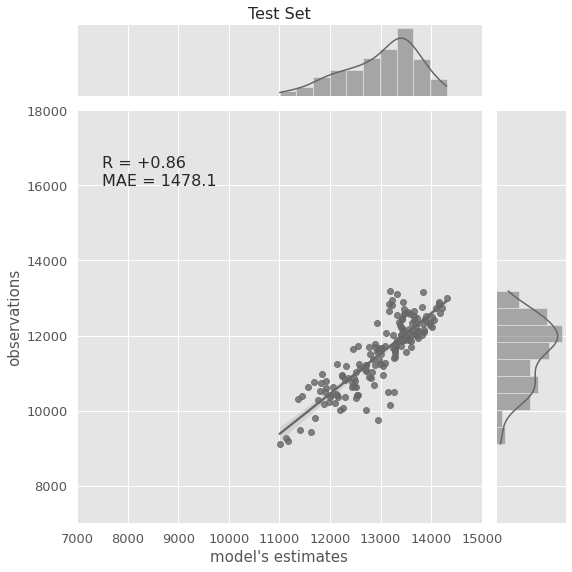

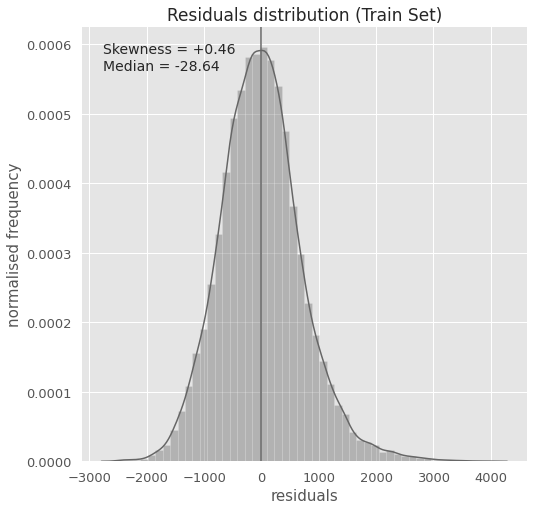

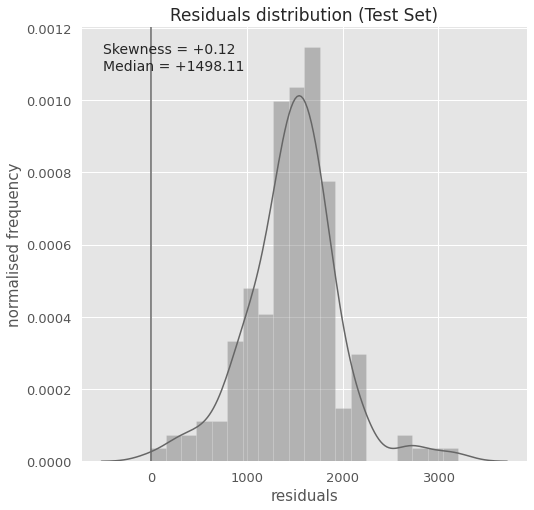

In [17]:
# validation

verification3_D7 = utils.df_verification(forecast3_D7, df_train_h, df_test_h)
verif_fig3_D7 = utils.plot_verification(verification3_D7, divider)
verif_fig3_D7_zoom = utils.plot_verification(verification3_D7[verification3_D7.index >= '2020-08-01'], divider)

mape3_D7 = utils.cv_mape(verification3_D7.y, verification3_D7.yhat)
print('Model 3 MAPE for D-7 forecasting: {}'.format(mape3_D7))

# plot joint plot for train set
verif_train3_D7 = verification3_D7[verification3_D7.index < divider]
mape3_train_D7 = utils.cv_mape(verif_train3_D7.y, verif_train3_D7.yhat)
print('Model 3 (Train Set) MAPE for D-7 forecasting: {}'.format(mape3_train_D7))
joint_train_plot3_D7 = utils.plot_joint_plot(verif_train3_D7, title='Train Set')

# plot joint plot for test set
verif_test3_D7 = verification3_D7[verification3_D7.index >= divider]
mape3_test_D7 = utils.cv_mape(verif_test3_D7.y, verif_test3_D7.yhat)
print('Model 3 (Test Set) MAPE for D-7 forecasting: {}'.format(mape3_test_D7))
joint_test_plot3_D7 = utils.plot_joint_plot(verif_test3_D7, title='Test Set')

# plot residual distribution plot for train set
residual_train_plot3_D7 = utils.plot_residuals_dist(verif_train3_D7, title='Train Set')

# plot residual distribution plot for test set
residual_test_plot3_D7 = utils.plot_residuals_dist(verif_test3_D7, title='Test Set')

#### D-1 forecasting

In [18]:
future3_D1 = m3.make_future_dataframe(freq='H', periods=24)
    
future_with_lockdown_regressors3_D1 = utils.add_lockdown_as_regressors(future3_D1)
future_with_regressors3_D1 = utils.add_regressor(future_with_lockdown_regressors3_D1, temp_h, varname='temp')

forecast3_D1 = m3.predict(future_with_regressors3_D1)

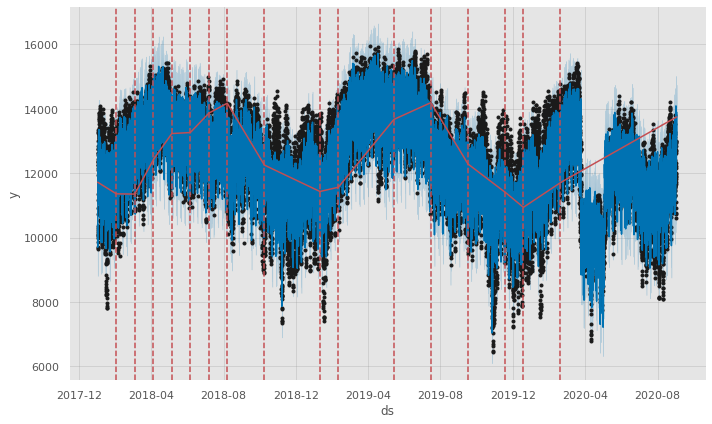

/home/yuchang/anaconda3/envs/ts/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


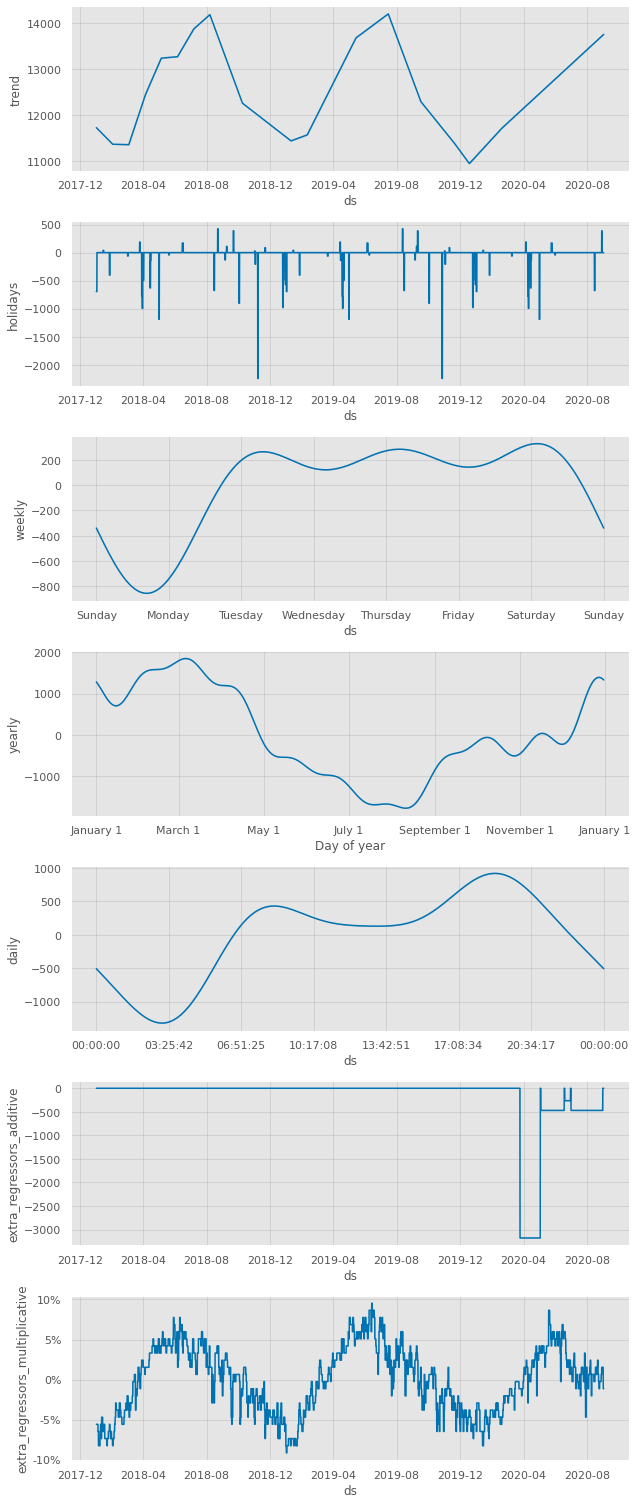

In [19]:
fig_changepoints3_D1 = utils.plot_changepoints(m3, forecast3_D1)
fig_components3_D1 = utils.plot_components(m3, forecast3_D1)

Model 3 MAPE for D-1 forecasting: 4.690568218384613
Model 3 (Train Set) MAPE for D-1 forecasting: 4.6873337918263
Model 3 (Test Set) MAPE for D-1 forecasting: 7.840899686181062


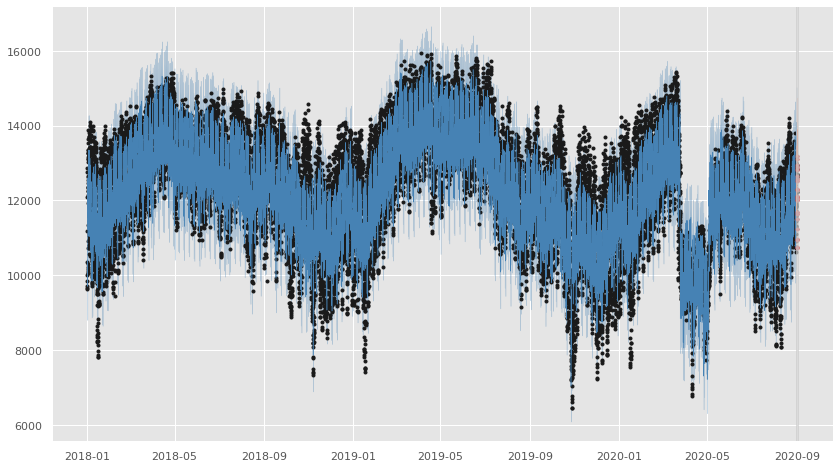

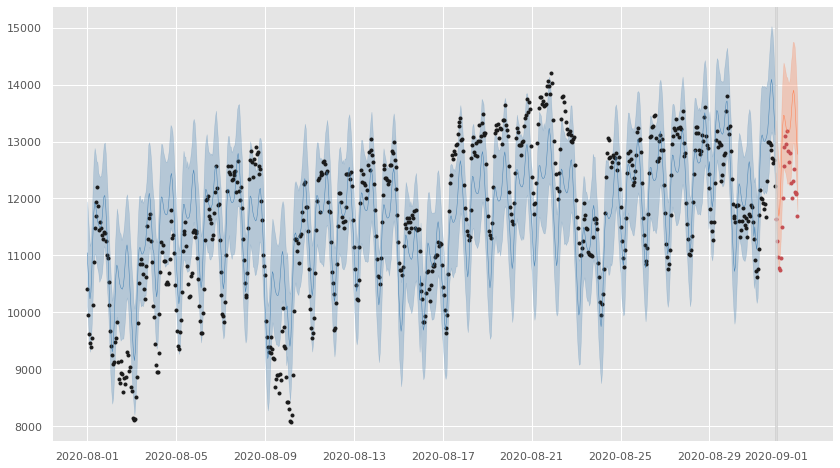

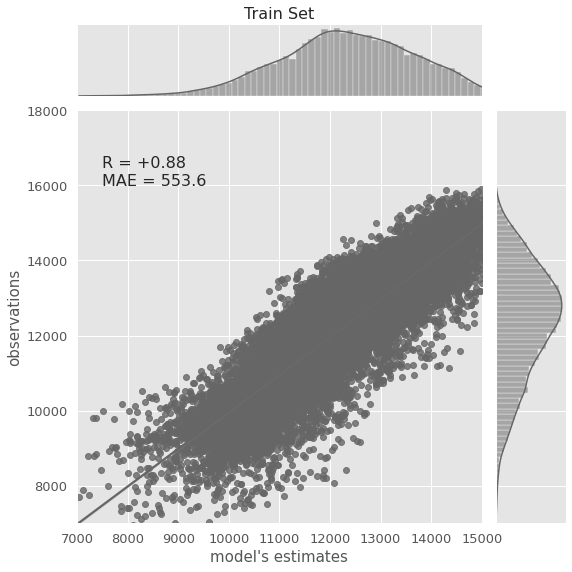

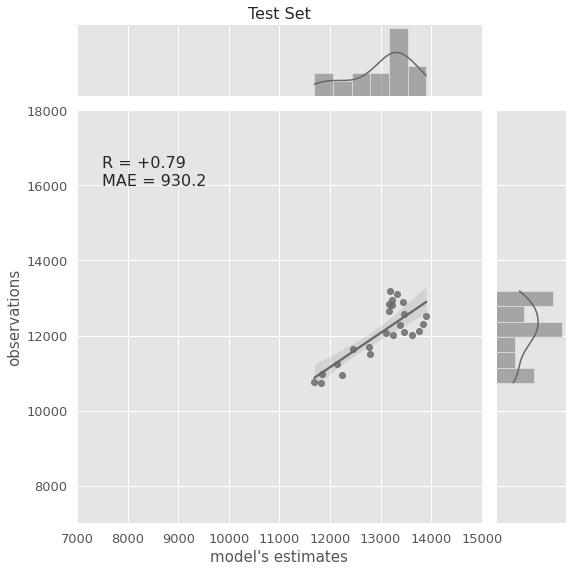

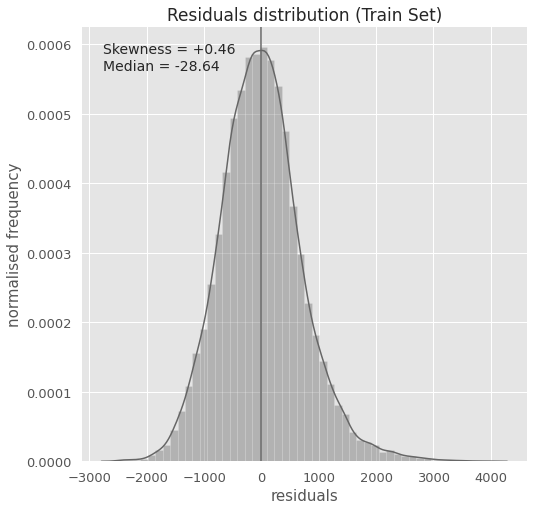

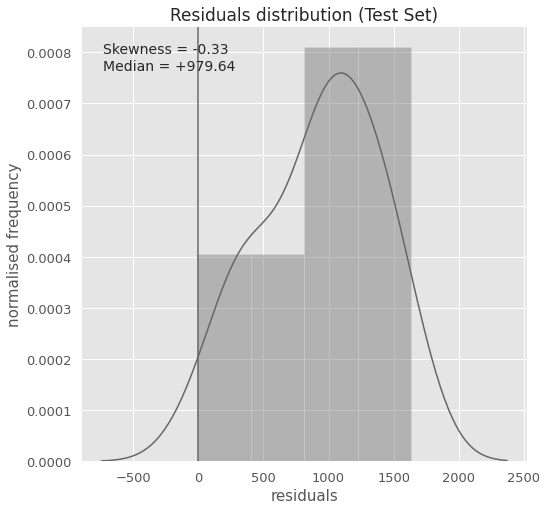

In [20]:
# validation

verification3_D1 = utils.df_verification(forecast3_D1, df_train_h, df_test_h)
verif_fig3_D1 = utils.plot_verification(verification3_D1, divider)
verif_fig3_D1_zoom = utils.plot_verification(verification3_D1[verification3_D1.index >= '2020-08-01'], divider)

mape3_D1 = utils.cv_mape(verification3_D1.y, verification3_D1.yhat)
print('Model 3 MAPE for D-1 forecasting: {}'.format(mape3_D1))

# plot joint plot for train set
verif_train3_D1 = verification3_D1[verification3_D1.index < divider]
mape3_train_D1 = utils.cv_mape(verif_train3_D1.y, verif_train3_D1.yhat)
print('Model 3 (Train Set) MAPE for D-1 forecasting: {}'.format(mape3_train_D1))
joint_train_plot3_D1 = utils.plot_joint_plot(verif_train3_D1, title='Train Set')

# plot joint plot for test set
verif_test3_D1 = verification3_D1[verification3_D1.index >= divider]
mape3_test_D1 = utils.cv_mape(verif_test3_D1.y, verif_test3_D1.yhat)
print('Model 3 (Test Set) MAPE for D-1 forecasting: {}'.format(mape3_test_D1))
joint_test_plot3_D1 = utils.plot_joint_plot(verif_test3_D1, title='Test Set')

# plot residual distribution plot for train set
residual_train_plot3_D1 = utils.plot_residuals_dist(verif_train3_D1, title='Train Set')

# plot residual distribution plot for test set
residual_test_plot3_D1 = utils.plot_residuals_dist(verif_test3_D1, title='Test Set')

#### H-4 forecasting

In [21]:
future3_H4 = m3.make_future_dataframe(freq='H', periods=4)

future_with_lockdown_regressors3_H4 = utils.add_lockdown_as_regressors(future3_H4)
future_with_regressors3_H4 = utils.add_regressor(future_with_lockdown_regressors3_H4, temp_h, varname='temp')

forecast3_H4 = m3.predict(future_with_regressors3_H4)

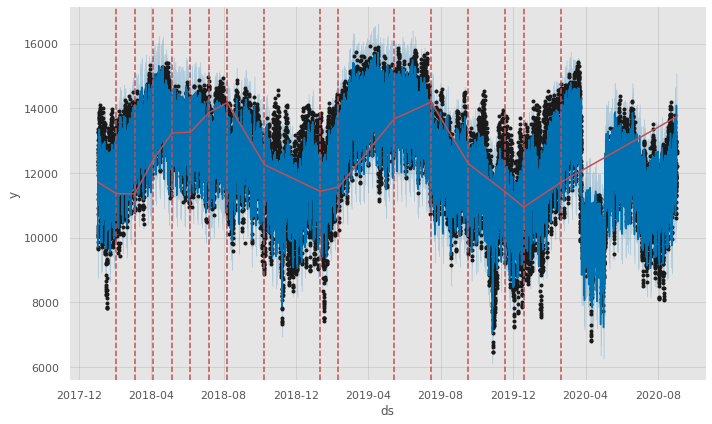

/home/yuchang/anaconda3/envs/ts/lib/python3.8/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


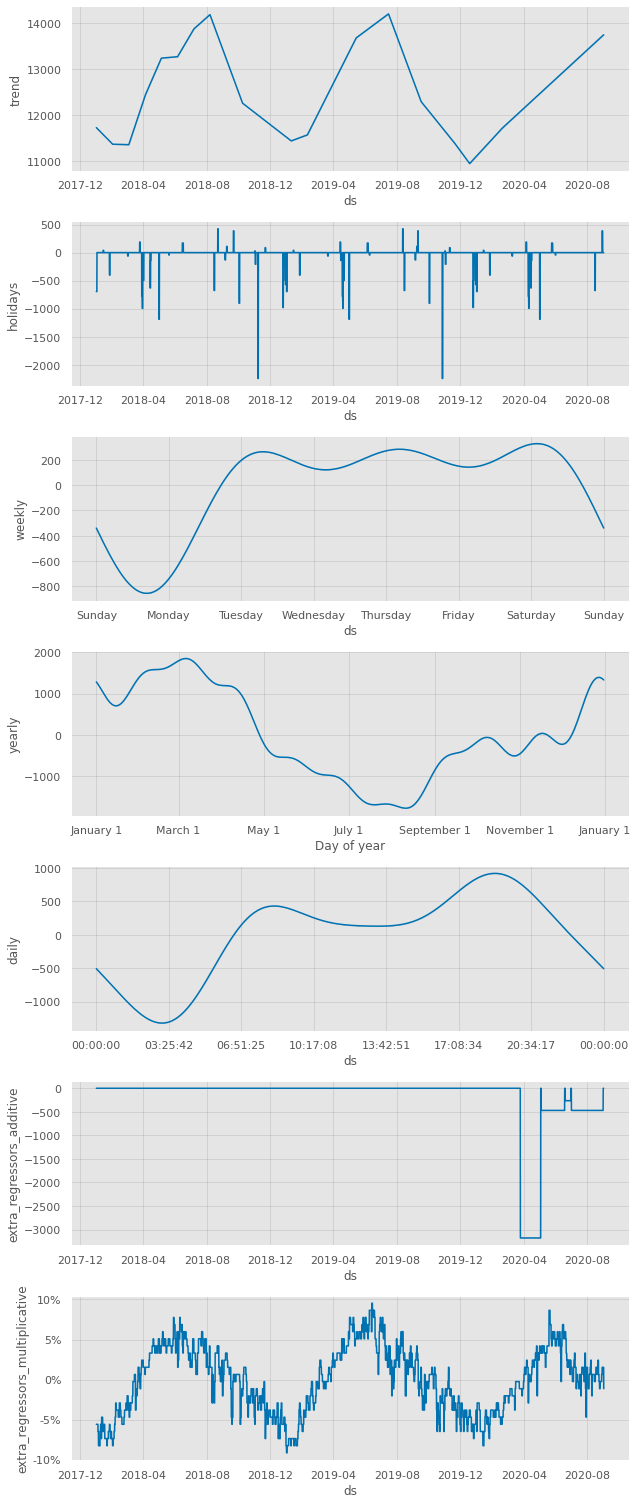

In [22]:
fig_changepoints3_H4 = utils.plot_changepoints(m3, forecast3_H4)
fig_components3_H4 = utils.plot_components(m3, forecast3_H4)

Model 3 MAPE for H-4 forecasting: 4.687864675672397
Model 3 (Train Set) MAPE for H-4 forecasting: 4.6873337918263
Model 3 (Test Set) MAPE for H-4 forecasting: 7.79034987226535


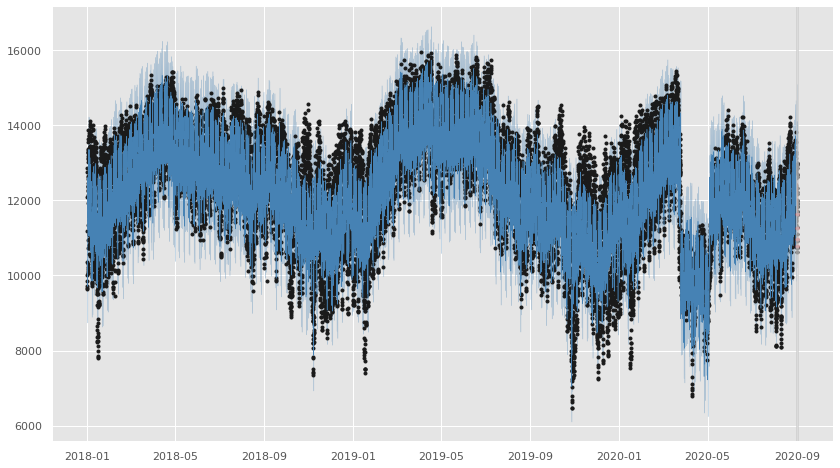

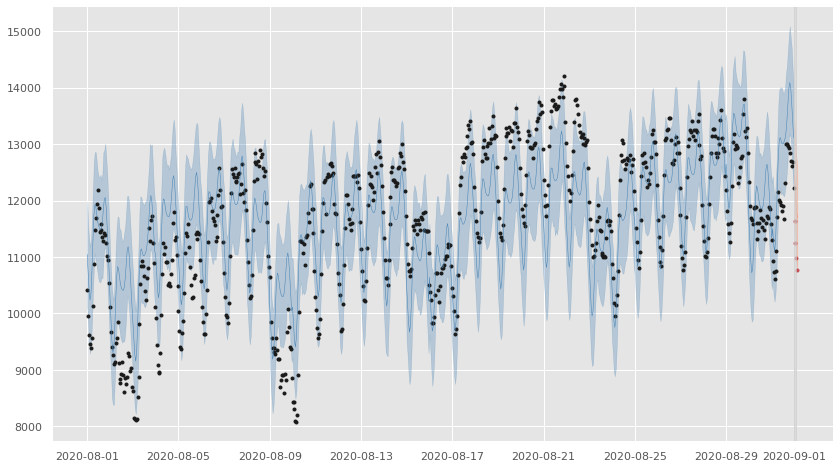

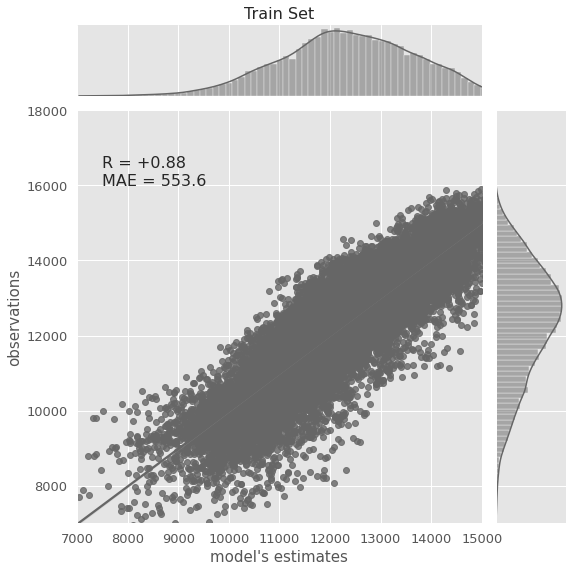

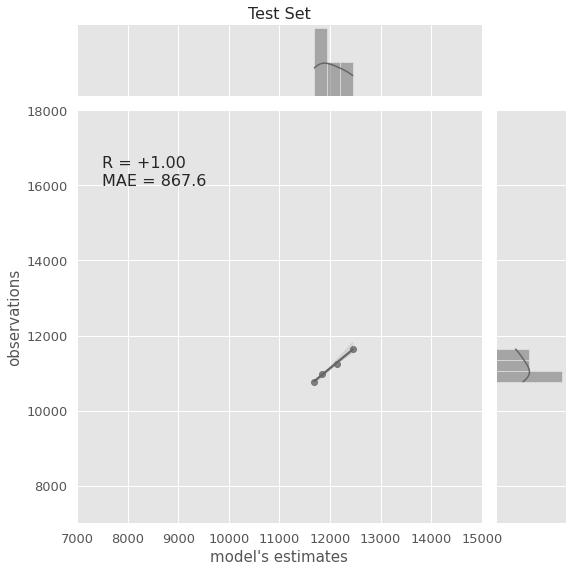

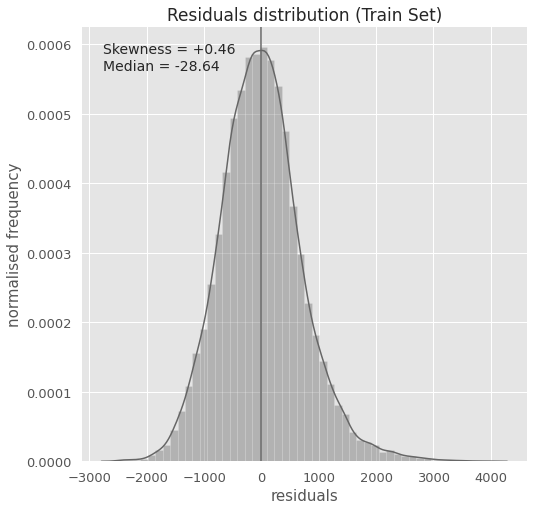

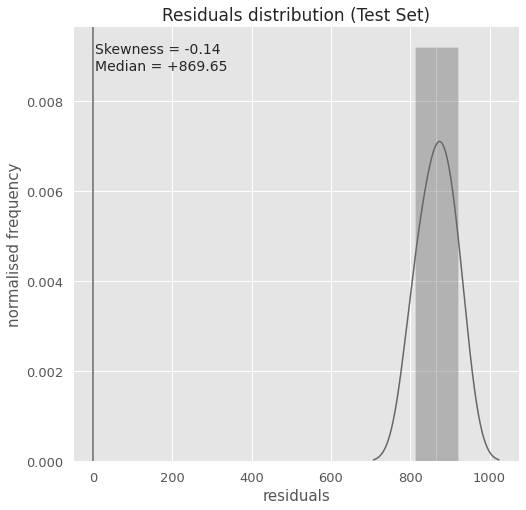

In [23]:
# validation

verification3_H4 = utils.df_verification(forecast3_H4, df_train_h, df_test_h)
verif_fig3_H4 = utils.plot_verification(verification3_H4, divider)
verif_fig3_H4_zoom = utils.plot_verification(verification3_H4[verification3_H4.index >= '2020-08-01'], divider)

mape3_H4 = utils.cv_mape(verification3_H4.y, verification3_H4.yhat)
print('Model 3 MAPE for H-4 forecasting: {}'.format(mape3_H4))

# plot joint plot for train set
verif_train3_H4 = verification3_H4[verification3_H4.index < divider]
mape3_train_H4 = utils.cv_mape(verif_train3_H4.y, verif_train3_H4.yhat)
print('Model 3 (Train Set) MAPE for H-4 forecasting: {}'.format(mape3_train_H4))
joint_train_plot3_H4 = utils.plot_joint_plot(verif_train3_H4, title='Train Set')

# plot joint plot for test set
verif_test3_H4 = verification3_H4[verification3_H4.index >= divider]
mape3_test_H4 = utils.cv_mape(verif_test3_H4.y, verif_test3_H4.yhat)
print('Model 3 (Test Set) MAPE for H-4 forecasting: {}'.format(mape3_test_H4))
joint_test_plot3_H4 = utils.plot_joint_plot(verif_test3_H4, title='Test Set')

# plot residual distribution plot for train set
residual_train_plot3_H4 = utils.plot_residuals_dist(verif_train3_H4, title='Train Set')

# plot residual distribution plot for test set
residual_test_plot3_H4 = utils.plot_residuals_dist(verif_test3_H4, title='Test Set')